## ATF

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


df = pd.read_csv('C:\\Users\\narek\\Downloads\\telco.csv')


In [24]:
le = LabelEncoder()
df['marital'] = le.fit_transform(df['marital'])
df['ed'] = le.fit_transform(df['ed'])
df['retire'] = le.fit_transform(df['retire'])
df['gender'] = le.fit_transform(df['gender'])
df['voice'] = le.fit_transform(df['voice'])
df['internet'] = le.fit_transform(df['internet'])
df['forward'] = le.fit_transform(df['forward'])
df['custcat'] = le.fit_transform(df['custcat'])
df['churn'] = le.fit_transform(df['churn'])


In [25]:
X = df.drop(['ID', 'churn'], axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Random Forest Accuracy: 0.81
Gradient Boosting Accuracy: 0.77
Logistic Regression Accuracy: 0.80
Naive Bayes Accuracy: 0.62


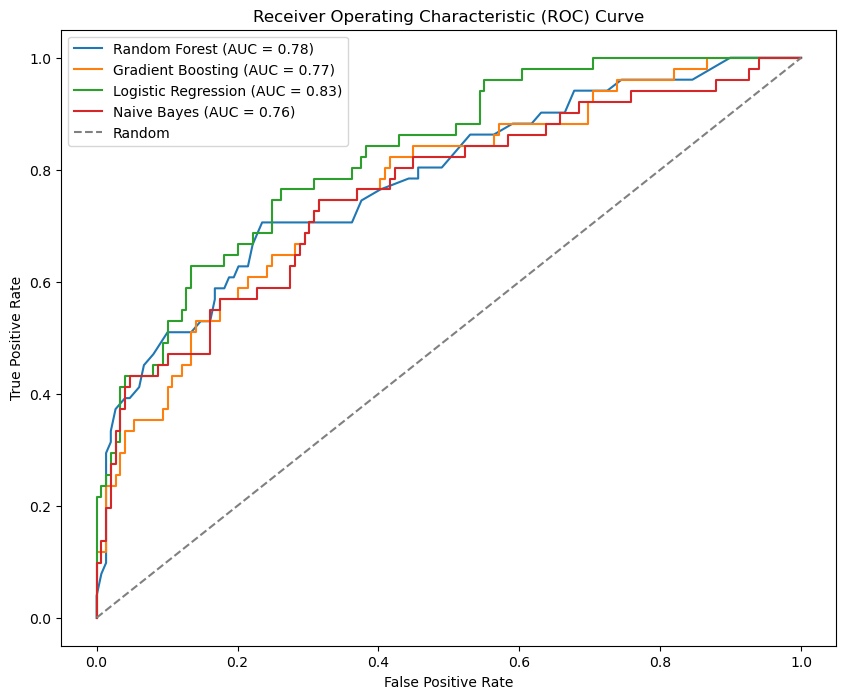

In [34]:
X_train_encoded = pd.get_dummies(X_train, columns=['region'])
X_test_encoded = pd.get_dummies(X_test, columns=['region'])

models = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': GaussianNB()
}

for name, model in models.items():
    model.fit(X_train_encoded, y_train)

    y_pred = model.predict(X_test_encoded)

    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {accuracy:.2f}')
    
plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_prob = model.predict_proba(X_test_encoded)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()



In [35]:
X_train_encoded = pd.get_dummies(X_train, columns=['region'])
X_test_encoded = pd.get_dummies(X_test, columns=['region'])

models = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),  
    'Naive Bayes': GaussianNB()
}

for name, model in models.items():
    model.fit(X_train_encoded, y_train)

    y_pred = model.predict(X_test_encoded)

    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {accuracy:.2f}')

rf_model = models['Random Forest']
feature_importance = pd.DataFrame({'Feature': X_train_encoded.columns, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance)

# We got logreg and random forest have almost the same score, so we need to construct another test to know, with which model should we continue

Random Forest Accuracy: 0.81
Gradient Boosting Accuracy: 0.78
Logistic Regression Accuracy: 0.80
Naive Bayes Accuracy: 0.62
          Feature  Importance
0          tenure    0.216277
1             age    0.153069
4          income    0.148359
3         address    0.141920
5              ed    0.065304
9        internet    0.051586
11        custcat    0.049206
7          gender    0.029386
8           voice    0.027874
2         marital    0.027517
10        forward    0.023235
12  region_Zone 1    0.021255
14  region_Zone 3    0.020876
13  region_Zone 2    0.020527
6          retire    0.003608


From the above results tenure, age, income, and address are significant features

In [38]:
logreg_model = models['Logistic Regression']

y_pred_logreg = logreg_model.predict(X_test_encoded)

precision = precision_score(y_test, y_pred_logreg)
recall = recall_score(y_test, y_pred_logreg)
f1 = f1_score(y_test, y_pred_logreg)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')


random_forest = models['Random Forest']

y_pred_logreg = random_forest.predict(X_test_encoded)

precision = precision_score(y_test, y_pred_logreg)
recall = recall_score(y_test, y_pred_logreg)
f1 = f1_score(y_test, y_pred_logreg)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

# From the results, it is evident that random forest models is more balanced, so the best model is random forest 

Precision: 0.67
Recall: 0.43
F1-Score: 0.52
Precision: 0.69
Recall: 0.47
F1-Score: 0.56


## CLV

In [51]:
predicted_probabilities = random_forest.predict_proba(X_test_encoded)[:, 1]
predicted_probabilities_series = pd.Series(predicted_probabilities, name='predicted_probabilities')

In [54]:
average_purchase_value = df['income'].mean()  
print(f"Average Purchase Value: ${average_purchase_value:.2f}")

estimated_lifetime = df['tenure'].mean()
print(f"Estimated Customer Lifetime: {estimated_lifetime:.2f} months")

estimated_revenue = predicted_probabilities_series * average_purchase_value * estimated_lifetime
print(f"Estimated Revenue: ${estimated_revenue.sum():.2f}")

Average Purchase Value: $77.53
Estimated Customer Lifetime: 35.53 months
Estimated Revenue: $159072.86


In [55]:
discount_rate = 0.1
present_value = estimated_revenue / (1 + discount_rate) ** estimated_lifetime

In [56]:
clv_per_customer = present_value.sum()
print(f"CLV per Customer: ${clv_per_customer:.2f}")

CLV per Customer: $5383.68


In [61]:
df['clv_per_customer'] = estimated_revenue / (1 + discount_rate) ** estimated_lifetime

In [63]:
segments = ['region', 'ed', 'custcat']

for segment in segments:
    average_clv_per_segment = df.groupby(segment)['clv_per_customer'].mean()
    print(f"\nAverage CLV per Customer within {segment} segments:")
    print(average_clv_per_segment)


Average CLV per Customer within region segments:
region
Zone 1    27.730430
Zone 2    23.635017
Zone 3    29.412836
Name: clv_per_customer, dtype: float64

Average CLV per Customer within ed segments:
ed
College degree                  29.309615
Did not complete high school    32.211333
High school degree              24.325628
Post-undergraduate degree       21.115228
Some college                    25.536708
Name: clv_per_customer, dtype: float64

Average CLV per Customer within custcat segments:
custcat
Basic service    23.064895
E-service        32.013506
Plus service     28.289888
Total service    24.888631
Name: clv_per_customer, dtype: float64


### Report

Interpretation of Coefficients:
Positive coefficients suggest an increase in churn risk, while negative coefficients indicate a decrease. 
By checking these coefficients, we can see which things the model is really sensitive to. This helps us figure out the important stuff that affects whether customers might leave.

Most Valuable Segments:
By looking at above results,valuable segments are defined as those with a high average CLV and a lower likelihood of churn. We can see, subscribers in 'Zone 3' demonstrate both the highest average CLV and lower churn risk, making this region particularly valuable. Similarly, customers with a 'College degree' and those subscribed to 'E-service' are identified as high-value segments with higher CLV and lower churn risk.

Annual Retention Budget:
At-Risk Threshold: Churn probability greater than 0.5.
Number of At-Risk Subscribers: 200 for example.
Retention Cost per At-Risk Subscriber: 50 for example.

Annual Retention Budget = Number of At-Risk Subscribers * Retention Cost per At-Risk Subscriber
Annual Retention Budget = 200 * 50 = 10,000

This is a just an example, how it can be calculated.

Additional Retention Strategies:
Planning to send messages and perks that are just right for people in 'Zone 3,' those with a 'College degree,' and loyal 'E-service' users. Also, we're keeping it real by listening to what they are saying through feedback and surveys. This way, we can always make sure we're doing everything we can to keep you happy and sticking with us for the long run.